In [41]:
# generic imports
import os
import time
import pickle
from pyprojroot import here
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import sys
# jax import
import jax
import jax.numpy as jnp
from jax import random
# numpyro import
import numpyro
import numpyro.distributions as dist
from numpyro.infer import NUTS, MCMC, Predictive
# arviz import
import arviz as az
# local imports
# Add code src directory to sys.path
sys.path.append(str(here() / "simulation study" / "src"))
from loader_jkt import load_data
from gp import gp_aggr, gp_aggr_count
from kernels import exp_sq_kernel
from plotting import plot_incidence_map, plot_process
# config
jax.config.update('jax_platform_name', 'cpu');
print(f'We are using {jax.devices()} under the hood.')
print(f'The default path is {here()}')

We are using [CpuDevice(id=0)] under the hood.
The default path is c:\Users\jessi\Documents\school\y4\s2\DSE4101\Individual\FYP codes\DSE_FYP


In [42]:
# load data
spatial_data = load_data()
print(spatial_data.keys())

dict_keys(['x', 'pol_pts_lo', 'pol_pts_hi', 'df_lo', 'df_hi'])


In [43]:
# Lets lok at the data and dissect it
lo_prev = spatial_data["df_lo"].copy()
lo_prev['incidence'] = (lo_prev.Cases / lo_prev.Population)
print("Dengue incidence by province and year (low resolution):")
print(lo_prev.groupby(['Province', 'Year'])[['incidence']].mean(), '\n')

# make sure we use only one year of data (change manually)
year_data = 2022
print(f'We are using data for the year {year_data}\n')

# let us filter the data for the years 2023, 2022, 2021, 2020 (must change the input manually for year_data)
df_lo = spatial_data["df_lo"][spatial_data["df_lo"].Year == year_data]
df_hi = spatial_data["df_hi"][spatial_data["df_hi"].Year == year_data]

df_lo = df_lo.copy()
df_hi = df_hi.copy()
df_lo.loc[:, 'incidence'] = df_lo.Cases / df_lo.Population
df_hi.loc[:, 'incidence'] = df_hi.Cases / df_hi.Population


Dengue incidence by province and year (low resolution):
                  incidence
Province    Year           
DKI Jakarta 2020   0.001519
            2021   0.001315
            2022   0.002667
            2023   0.001983 

We are using data for the year 2022



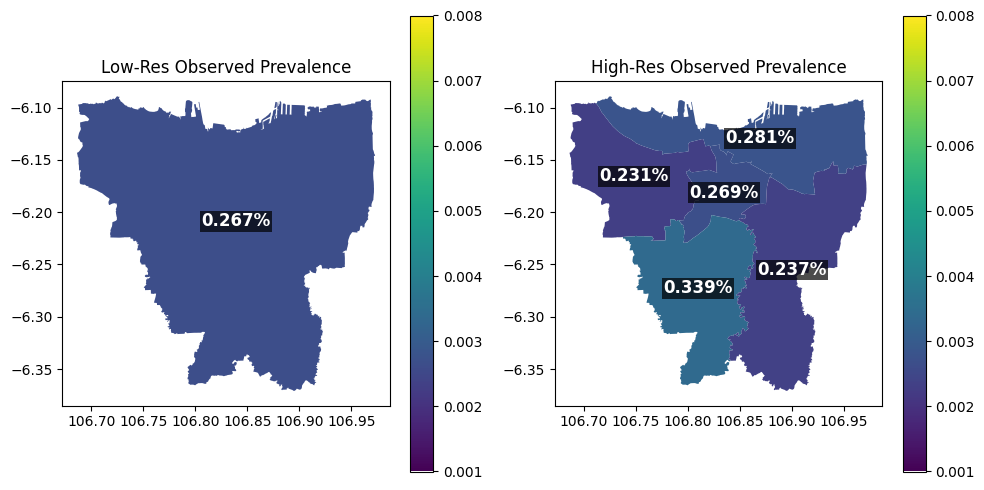

In [44]:
# Plot data using the reusable function
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Plot low resolution data
plot_incidence_map(df_lo, ax = ax[0], title = "Low-Res Observed Prevalence")

# Plot high resolution data
plot_incidence_map(df_hi, ax = ax[1], title = "High-Res Observed Prevalence")

plt.tight_layout()
plt.show()


In [45]:
# Lets look at agg_gp by drawing samples from it
# Define the configuration
config = {
    'x': spatial_data["x"],
    'gp_kernel': exp_sq_kernel,
    'noise': 1e-2,
    'jitter': 1e-2,
    'M_lo': jnp.array(spatial_data["pol_pts_lo"]),
    'M_hi': jnp.array(spatial_data["pol_pts_hi"]),
    'kernel_length': dist.InverseGamma(5, 2),
    'kernel_var': dist.LogNormal(-1, 0.05)
}

# Draw samples from the prior
prior_samples = Predictive(gp_aggr, num_samples=1000)(
    random.PRNGKey(6),
    config=config
)

In [46]:
# transform prior samples to arviz inference object
prior_samples_arviz = az.from_numpyro(prior=prior_samples)

In [47]:
total_population = jnp.concatenate([df_lo.Population.values, df_hi.Population.values])
count = jnp.concatenate([df_lo.Cases.values, jnp.full((df_hi.shape[0],), jnp.nan)])
hdi_index = jnp.concatenate([df_lo.HDI.values, df_hi.HDI.values])*100
pop_density = jnp.concatenate([df_lo.Pop_den.values*1e2, (df_hi.Pop_den.values)*1e-1])
urban_frac = jnp.concatenate([df_lo.urbanicity.values, df_hi.urbanicity.values])*100

In [48]:
# Define the configuration
config_count = {
    'x': spatial_data["x"],
    'gp_kernel': exp_sq_kernel,
    'noise': 1e-2,
    'jitter': 1e-2,
    'M_lo': jnp.array(spatial_data["pol_pts_lo"]),
    'M_hi': jnp.array(spatial_data["pol_pts_hi"]),
    'kernel_length': dist.InverseGamma(5, 2),
    'kernel_var': dist.LogNormal(-1, 0.05),
    'total_population': total_population,
    'pop_density': pop_density,
    'hdi_index': hdi_index,
    'urban_frac': urban_frac,
    'count': count,
    'prior_pred': True
}

In [49]:
# Draw samples from the prior
prior_gp_count = Predictive(gp_aggr_count, num_samples=1000)(
    random.PRNGKey(6),
    config=config_count
)
# arviz inference object count model prior
# transform prior samples to arviz inference object
prior_gp_count_arviz = az.from_numpyro(prior=prior_gp_count)

In [50]:
# Plot the process
plot_process(prior_gp_count_arviz.prior.pred_cases.values)

In [51]:
# Run MCMC
# Base seed for reproducibility
base_seed = 30  # Keep this fixed for full replicability
# MCMC settings
n_warm = 2000
n_samples = 2000
rng = jax.random.PRNGKey(base_seed)

# Define the model
model = gp_aggr_count

# Define the sampler
sampler = NUTS(model)
mcmc = MCMC(sampler, # change for later run to target_accept_prob = 0.99 and max_tree_depth = 20
            num_warmup=n_warm,
            num_samples=n_samples,
            num_chains=4,
            chain_method="vectorized",
            progress_bar=True
            )
start = time.time()
mcmc.run(rng, config_count)
end = time.time()
t_elapsed_min = round((end - start) / 60)
print(f"Time taken to run MCMC: {t_elapsed_min} minutes")
# %%

sample: 100%|██████████| 4000/4000 [19:26<00:00,  3.43it/s] 

Time taken to run MCMC: 19 minutes


In [52]:
#save the mcmc from gp for jkt for each specific year (change the year manually)

# Define the path where you want to save the MCMC files
base_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))  # this assumes you are in the 'src' folder
model_weights_dir = os.path.join(base_dir, 'model weights', 'aggGP')

# Make sure the directory exists, otherwise create it
if not os.path.exists(model_weights_dir):
    os.makedirs(model_weights_dir)

# Define the file path where to save the MCMC object
file_path = os.path.join(model_weights_dir, f"mcmc_jkt_{year_data}_{t_elapsed_min}min.pkl")
    

# Save the MCMC object as a pickle file
with open(file_path, 'wb') as f:
        pickle.dump(mcmc, f)

print(f"MCMC object for year {year_data} saved successfully at {file_path}.")

MCMC object for year 2022 saved successfully at c:\Users\jessi\Documents\school\y4\s2\DSE4101\Individual\FYP codes\DSE_FYP\simulation study\model weights\aggGP\mcmc_jkt_2022_19min.pkl.


# MCMC Inference

In [53]:
# creating  prior and posterior predictive
rng_key_pr, rng_key_po = random.split(random.PRNGKey(4))
posterior_samples = mcmc.get_samples()
posterior_predictive = Predictive(model, posterior_samples)(
    rng_key_po, config_count
)
prior = Predictive(model, num_samples=500)(
    rng_key_pr, config_count
)
# transform prior and posterior predictive to arviz inference objects
Total_districts = df_lo.shape[0] + df_hi.shape[0]
numpyro_data = az.from_numpyro(
    mcmc,
    prior=prior,
    posterior_predictive=posterior_predictive,
    coords={"district": np.arange(Total_districts)},
    dims={"lp": ["district"]},
)

In [54]:
print(mcmc.print_summary())
az.summary(numpyro_data, var_names = ["pred_cases", "lp", "b0", "b_pop_density", "b_hdi", "b_urban", "aggr_gp"])


                     mean       std    median      5.0%     95.0%     n_eff     r_hat
             b0     98.63     10.05     98.07     81.28    113.77    138.25      1.04
          b_hdi     -0.09      0.95     -0.10     -1.54      1.52    360.36      1.02
  b_pop_density     -0.04      1.02     -0.01     -1.84      1.54     99.61      1.05
        b_urban      0.09      1.11      0.03     -1.56      2.03     34.75      1.09
  kernel_length      0.48      0.28      0.41      0.17      0.80    520.07      1.01
     kernel_var      0.37      0.02      0.37      0.34      0.40    974.92      1.01
       log_f[0]      2.99      0.60      2.96      2.13      3.97     23.40      1.18
       log_f[1]      2.97      0.57      2.98      2.10      3.86     32.33      1.13
       log_f[2]      2.96      0.58      2.93      2.09      3.88     18.58      1.18
       log_f[3]      2.95      0.57      2.92      2.08      3.85     26.83      1.14
       log_f[4]      2.96      0.58      2.95      2.

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
pred_cases[0],1346.186,733.580,224.303,2532.412,138.490,53.772,17.0,57.0,1.18
pred_cases[1],318.423,189.568,-14.025,648.074,32.703,8.319,31.0,291.0,1.10
pred_cases[2],211.698,151.312,-47.398,478.674,23.053,4.664,46.0,441.0,1.07
pred_cases[3],369.228,214.391,7.165,738.083,43.282,9.236,24.0,371.0,1.13
pred_cases[4],453.241,247.732,1.091,850.350,43.384,13.950,27.0,233.0,1.12
pred_cases[5],400.570,223.066,24.322,796.868,36.038,13.080,29.0,184.0,1.12
lp[0],1346.121,731.692,227.244,2525.865,138.207,53.875,17.0,50.0,1.18
lp[1],319.130,181.510,0.000,601.111,32.502,8.354,29.0,281.0,1.11
lp[2],212.524,141.370,0.000,440.162,23.389,4.911,40.0,379.0,1.08
lp[3],369.035,207.876,0.000,687.825,42.991,9.554,23.0,326.0,1.14


In [55]:
# stacked data
mean_pred_cases = numpyro_data.posterior.pred_cases.values.mean(axis=(0,1))
df_lo['pred_cases'] = mean_pred_cases[:df_lo.shape[0]] / df_lo.Population
df_hi['pred_cases'] = mean_pred_cases[df_lo.shape[0]:] / df_hi.Population
# %%

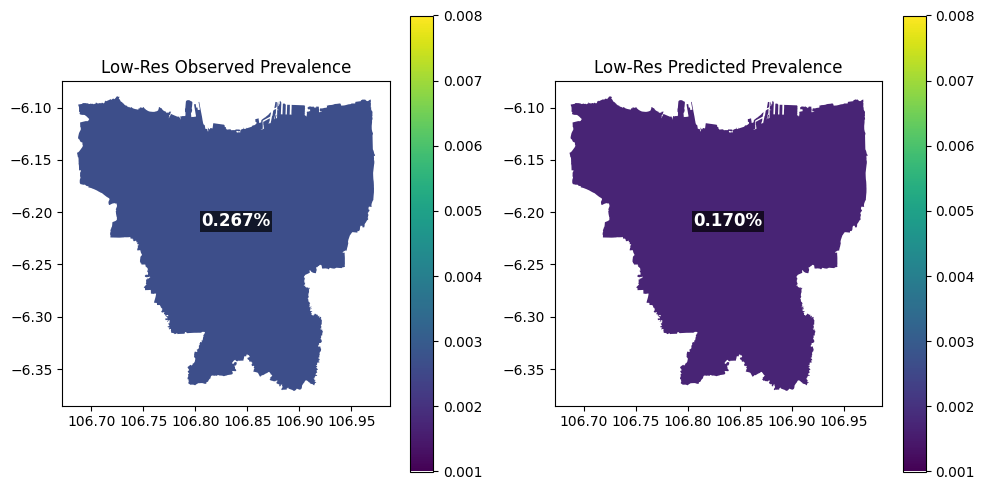

In [56]:
# Plot the process
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plot_incidence_map(df_lo, ax = ax[0], title = "Low-Res Observed Prevalence")
plot_incidence_map(df_lo, plot_col = 'pred_cases', ax = ax[1], title = "Low-Res Predicted Prevalence")
plt.tight_layout()
plt.show()

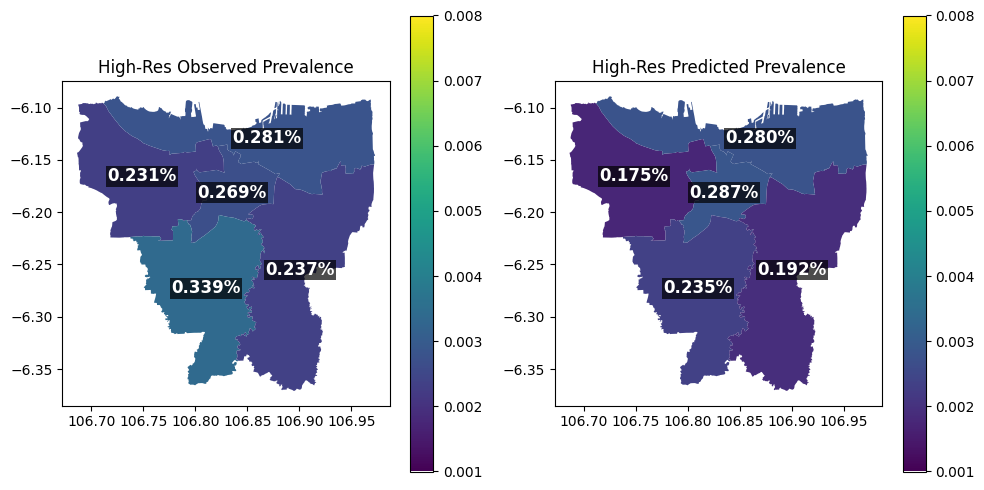

In [57]:
# Plot the process
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plot_incidence_map(df_hi, ax = ax[0], title = "High-Res Observed Prevalence")
plot_incidence_map(df_hi, plot_col = 'pred_cases', ax = ax[1], title = "High-Res Predicted Prevalence")
plt.tight_layout()
plt.show()

In [58]:
#save the dfs for jkt dist and province dfs with predictions - change the year accordingly (do one by one from 2023 to 2020)
#df_hi.to_csv("../data/df_hi_jkt_w_pred_2022.csv")